# Dimensionalidad

## Aprendizaje No Supervisado

- **Definición**: Ausencia de información previa sobre el _vector objetivo_.
- Tipos de aprendizaje no supervisado:
    - Reducción de dimensionalidad: Se utiliza para reducir la cantidad de atributos, generando nuevos atributos que representen a los originales.
    - Clustering (agrupación): Se utiliza para generar / descubrir _agrupaciones_ dentro de los datos.

## La maldición de la dimensionalidad

- Un problema en varias áreas relacionadas a las que estamos estudiando surge cuando este número de dimensiones aumenta mucho en comparación con la cantidad de ejemplos.
    - La cantidad de combinaciones posibles entre los valores que pueden tomar las dimensiones (columnas) de los ejemplos de la muestra es mucho mayor a la cantidad de ejemplos en la misma
    - Los puntos en este espacio hiperdimensional estarán dispersos
<br />
<br />
- El problema es que la convergencia de cualquier estimador al parámetro verdadero de una función definida en un espacio d-dimensional es muy lento dado al exceso de atributos y falta de observaciones

In [31]:
import lec7_graphs as gfx
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(style=None, font_scale=1.5)

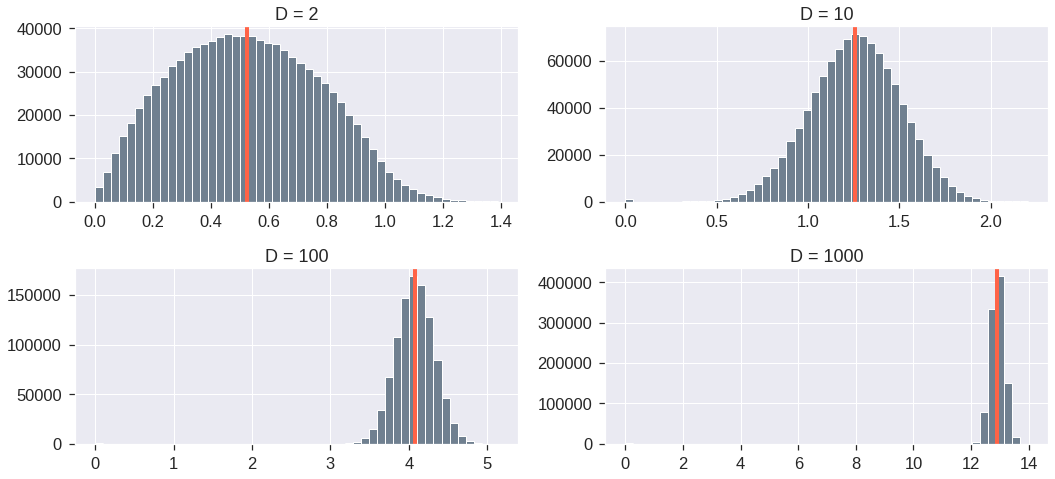

In [2]:
plt.figure(figsize=(15,7))
for i, e in enumerate([2, 10, 100, 1000]):
    plt.subplot(2,2, i+1)
    gfx.sim_distance(e)
    plt.tight_layout()

- En la medida que aumentamos artificialmente la cantidad de dimensiones, la distancia promedio entre dos puntos aumenta substancialmente.

# Dimensionalidad desde la Psicometría

## Objetivos del Análisis Factorial

- **Objetivo**: Extraer la variabilidad de un conjunto finito de variables y transformarla en una serie de _factores latentes_, reduciendo así la dimensionalidad.
- Busca identificar una serie de “factores causales” condicionales a un conjunto de datos donde la cantidad de dimensiones es sustancialmente superior a los registros existentes.

<img src="https://miro.medium.com/max/1226/0*MziWDM59JTX6XB4d.png" />

## Pasos de Implementación

- Definimos una batería de preguntas:
    - Observamos la escala de los datos. Si las escalas son heterogéneas, podemos estandarizar.
    
- Eliminamos / imputamos valores perdidos.
- Generamos métricas de validación.
- Evaluamos la cantidad de factores.
- Inferimos características de los factores

In [32]:
import pandas as pd

df = pd.read_csv("cep45.csv")
df.head()

,corr,filtro,psu,region,p1_1,p1_2,p1_3,p2,p3,p4,...,de14_b,de14_c,de14_d,de14_e,de14_f,de15,de16,de17,b5,pond
0,1,937,150,13,9,3,6,1,3,2,...,2,2,2,2,2,6,4,4,1,0.782461
1,2,938,150,13,7,6,3,2,2,1,...,2,2,1,2,2,8,4,4,1,1.157864
2,3,939,150,13,3,6,9,2,2,3,...,2,2,2,2,2,9,6,4,1,1.204037
3,4,1096,182,13,3,4,11,3,2,2,...,2,2,2,2,2,6,3,3,1,1.025330
4,5,1097,182,13,6,11,7,3,1,1,...,2,2,2,2,2,6,3,3,1,1.204037


- El objetivo es analizar la batería de preguntas asociadas a la confianza institucional (aquellas que empiezan con `p17`)

In [40]:
trust_df = df.filter(regex="p17_*")

# Se cambia el nombre de las columnas según la información entregada en la lectura
trust_df = trust_df.rename(columns={
    'p17_a': 'I.Catolica',
    'p17_b': 'I.Evangelica',
    'p17_c': 'FFAA',
    'p17_d': 'Justicia',
    'p17_e': 'Prensa',
    'p17_f': 'Television',
    'p17_g':'Sindicatos',
    'p17_h':'Carabineros',
    'p17_i': 'Gobierno',
    'p17_j': 'PartidosPol',
    'p17_k': 'Congreso',
    'p17_l':'Empresas',
    'p17_m':'Universidades',
    'p17_n':'Radio'
})
trust_df.head()

,I.Catolica,I.Evangelica,FFAA,Justicia,Prensa,Television,Sindicatos,Carabineros,Gobierno,PartidosPol,Congreso,Empresas,Universidades,Radio
0,2,4,3,2,3,3,3,4,3,3,2,3,2,2
1,2,3,3,3,3,3,2,2,3,4,3,3,3,3
2,4,4,4,4,3,3,4,4,4,4,4,3,4,2
3,1,3,2,2,3,2,3,3,3,4,3,3,3,3
4,3,3,2,1,2,2,1,1,2,3,2,2,2,2


- En estas preguntas, los datos _nulos_ vienen codificados como 8 y 9, por lo que se debe hacer su reemplazo por `np.nan` para su visualización
- Podemos visualizar la presencia de datos perdidos con la libreria `missingno`
```python
pip install missingno
```

In [41]:
!pip install missingno

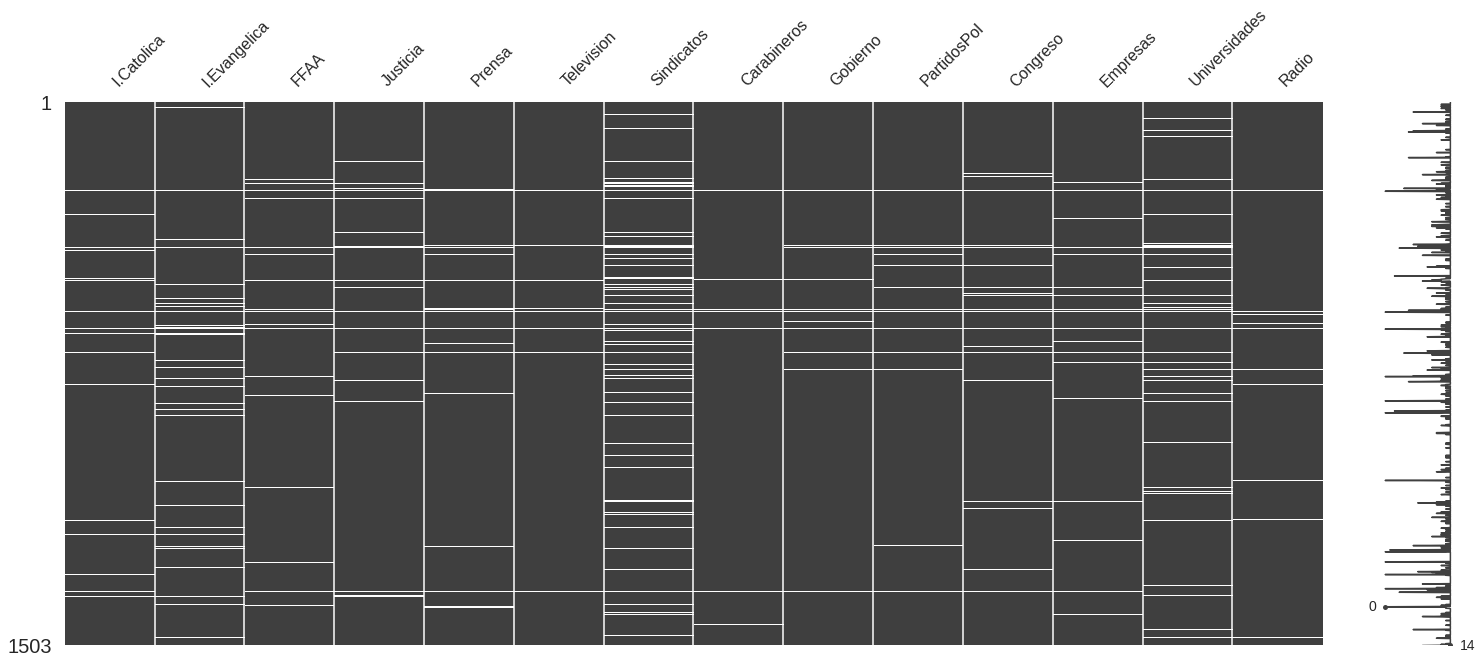

In [42]:
import missingno as msngo
import numpy as np

msngo.matrix(trust_df.replace([8, 9], [np.nan, np.nan]));

In [43]:
# En este caso, eliminaremos los datos nulos en lugar de imputarlos
print(trust_df.shape)
trust_df = trust_df.replace([8, 9], [np.nan, np.nan]).dropna()
print(trust_df.shape)

(1503, 14)
(1161, 14)


### Implementación en Python

- Para implementar un análisis factorial en Python, utilizaremos la librería factor_analyzer.
```bash
pip install factor_analyzer
```

In [8]:
!pip install factor_analyzer

In [44]:
import factor_analyzer as fact

## Prueba de Esferacidad de Bartlett

- Antes de realizar el análisis factorial, se debe asegurar que las columnas "tengan cierta relación entre sí". Es decir, la matriz de correlaciones _no_ debe ser una matriz de identidad.
- Esto se puede comprobar mediante un test de hipótesis, conocido como la prueba de esferacidad de Bartlett
    - **Hipótesis Nula**: La matriz de correlaciones _es_ una matriz de identidad.
    - **Hipótesis Alternativa**: La matriz de correlaciones _no es_ una matriz de identidad.

In [45]:
estadistico, pvalor = fact.calculate_bartlett_sphericity(trust_df)

print(f"{'Es' if pvalor > 0.05 else 'No es'} una matriz de identidad")

No es una matriz de identidad


## Prueba Kaiser-Meyer-Olkin
- Responde a la pregunta: _¿Son las correlaciones parciales entre dos ítems cercanas a 0?_
- Se sugiere que para seguir con el análisis factorial, el KMO debe presentar valores superiores a .7. En este caso se satisface el punto y podemos proseguir.

In [47]:
kmos_individuales, kmo_general = fact.calculate_kmo(trust_df)

assert kmo_general > 0.7
assert np.all(kmos_individuales > 0.7)

print(f"El KMO general es de {kmo_general}")
print(f"Los KMO individuales son {kmos_individuales}")

El KMO general es de 0.8299274694302806
Los KMO individuales son [0.86557747 0.79657238 0.76437479 0.86632914 0.78116369 0.81936633
 0.87495149 0.81795218 0.83286064 0.81661127 0.849795   0.88921644
 0.87071149 0.8100461 ]


## Definiendo cantidad de factores

### ¿Qué tantos factores necesitamos?

- Para ello, Analizamos los eigenvalues (valores propios) de la descomposición de la matriz.
- Estos informan qué tanta varianza se puede atribuir un factor en específico.
- La manera más simple de analizar esto es mediante un _scree plot_ (gráfico de sedimentación), que visualiza los eigenvalues en la medida que se aumenta la cantidad de factores. 
- Por convención no pueden existir más factores que variables dentro de la matriz.
- La cantidad de factores a utilizar corresponde a la cantidad de valores propios obtenidos con valor $\geq 1$.

### Sobre los tipos de rotación

- Las cargas $\lambda$ no tienen una identificación única, por lo que se puede emplear una "rotación" de la matriz para encontrar una mejor estructura latente.
- Están los métodos _ortogonales_ (que no permiten correlación entre factores) y _oblicuos_ (que sí permiten correlación entre factores). Algunas de las más utilizadas son:
    - _Varimax_: Rotación que busca maximizar la varianza de las cargas para cada factor.
    - _Quartimax_: Rotación que busca maximizar la varianza de las cargas y tiende a producir cargas más altas para cada variable

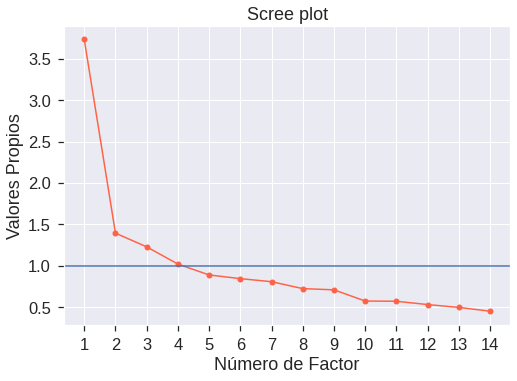

In [48]:
factorize = fact.FactorAnalyzer(
    n_factors=14,                # Cuántos factores queremos extraer
    rotation='varimax'           # Tipo de rotación. En general se usa varimax.
)

# Implementamos el análisis
factorize.fit(trust_df)

# Extraemos los eigenvalues
factor_screeplot = factorize.get_eigenvalues()[0]

# Graficamos los eigenvalues contra la cantidad de dimensiones estimables
plt.plot(range(1, len(factor_screeplot) + 1), factor_screeplot, 'o-',
color='tomato')
plt.xlabel('Número de Factor')
plt.ylabel('Valores Propios')
plt.xticks(range(1, len(factor_screeplot) + 1))

# Visualizamos el criterio de corte
plt.axhline(1)
plt.title("Scree plot");

- En este caso, corresponde a 4 factores.
- Se realiza nuevamente el análisis factorial para 4 factores, y se consulta por las cargas $\lambda$ generadas.

In [52]:
analisis_4_fact = fact.FactorAnalyzer(n_factors=4, rotation='varimax')
analisis_4_fact.fit(trust_df)

# Se genera un DF de 4 columnas, donde cada columna corresponde a cada factor, y cada fila a uno de los atributos del DF usado para obtener los factores.
# El cruce corresponde a la carga (lambda) que da el atributo (f) al factor correspondiente.
loads = pd.DataFrame(
    analisis_4_fact.loadings_,
    columns=["Factor 1", "Factor 2", "Factor 3", "Factor 4"],
    index=trust_df.columns
)
loads

,Factor 1,Factor 2,Factor 3,Factor 4
I.Catolica,0.186713,0.285615,0.085592,0.071474
I.Evangelica,0.146270,0.138316,0.012027,0.100286
FFAA,0.050131,0.765111,0.047241,0.082542
Justicia,0.371998,0.445211,0.106942,0.003974
Prensa,0.149283,0.126204,0.742653,-0.029003
Television,0.168111,0.167874,0.620157,0.100443
Sindicatos,0.361174,0.091376,0.153043,0.195945
Carabineros,0.115105,0.521690,0.179319,0.109257
Gobierno,0.516190,0.129039,0.112286,0.299335
PartidosPol,0.632349,0.092745,0.130463,-0.022737


## Interpretación de factores

- Nos fijamos en la magnitud y dirección de las cargas:
    - **Magnitud**: Predominancia en el factor latente. Normalmente se considera cargas mayores a 0.4.
    - **Dirección**: Asociación con el factor latente.

In [57]:
# Magnitud
loads[loads > .4].fillna(0).round(3).style.format('{:.2f}').background_gradient(cmap='Purples').applymap(lambda x: 'color: transparent' if x == 0 else '')

,Factor 1,Factor 2,Factor 3,Factor 4
I.Catolica,0.00,0.00,0.00,0.00
I.Evangelica,0.00,0.00,0.00,0.00
FFAA,0.00,0.77,0.00,0.00
Justicia,0.00,0.45,0.00,0.00
Prensa,0.00,0.00,0.74,0.00
Television,0.00,0.00,0.62,0.00
Sindicatos,0.00,0.00,0.00,0.00
Carabineros,0.00,0.52,0.00,0.00
Gobierno,0.52,0.00,0.00,0.00
PartidosPol,0.63,0.00,0.00,0.00


- En general, las instituciones tienen alta carga en 1 de los factores.
- El Factor 1 tiene cargas más altas en instituciones relacionadas con política, mientras que el Factor 2 tiene cargas más altas en instituciones de defensa, y el Factor 3 en medios de comunicación.

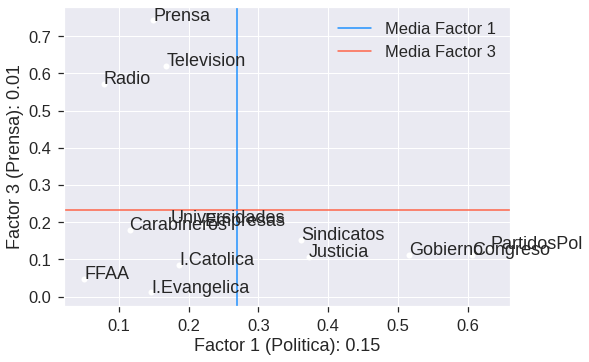

In [58]:
# Dirección

# Guardemos la varianza explicada por cada dimensión
factor_var = analisis_4_fact.get_factor_variance()

# Cruzamos ambos factores
plt.plot(loads["Factor 1"], loads["Factor 3"], 'o', color='white')

# Para cada elemento en los factores
for i, txt in enumerate(loads.index):
    # Anotemos el nombre de la variable
    plt.annotate(txt, (loads["Factor 1"][i], loads["Factor 3"][i]))

# Grafiquemos la media de ambos factores
plt.axvline(loads["Factor 1"].mean(), label="Media Factor 1", color="dodgerblue")
plt.axhline(loads["Factor 3"].mean(), label="Media Factor 3", color="tomato")

# Reportemos la varianza de cada dimensión
plt.xlabel('Factor 1 (Politica): {}'.format(round(loads["Factor 1"][1], 2)))
plt.ylabel('Factor 3 (Prensa): {}'.format(round(loads["Factor 3"][1], 2)))

plt.legend();

### Varianza explicada

- También podemos extraer la varianza explicada por cada dimensión latente.
- Cada dimensión estimada busca maximizar la varianza de la matriz. 
- Podemos obtener la varianza explicada de cada dimensión con `get_factor_variance`. 
- **Punto a considerar**: Los métodos de aprendizaje no supervisado no están exentos del trueque entre sesgo y varianza
    - Mientras que un modelo con más dimensiones puede aumentar la cantidad de varianza explicada, se hace a expensas de generar un modelo menos parsimonioso y difícil de interpretar.

In [16]:
# RETORNO: Cada fila que retorna get_factor_variance contiene:
# 1. Sum of squared loadings (variance)
# 2. Proportional variance
# 3. Cumulative variance

factor_var = analisis_4_fact.get_factor_variance()
factor_var = pd.DataFrame(factor_var, columns=["Factor 1", "Factor 2", "Factor 3", "Factor 4"], index=[
    "Sum of squared loadings (variance)", "Proportional variance", "Cumulative variance"
])
factor_var

,Factor 1,Factor 2,Factor 3,Factor 4
Sum of squared loadings (variance),1.511375,1.481227,1.458048,0.454495
Proportional variance,0.107955,0.105802,0.104146,0.032464
Cumulative variance,0.107955,0.213757,0.317904,0.350367


### Puntajes

- Cada factor se presentaba como la combinación lineal entre las cargas y las respuestas de cada ítem.
- Como tal, se pueden extraer los puntajes estimados entre ambos elementos mediante el método `transform` para cada factor generado.
- Estos puntajes vienen dados por la estandarización de los factores, por lo que $\sim \mathcal{N}(0, \sigma^2)$.
- Los puntajes pueden ser utilizados posteriormente en modelos predictivos como variables dependientes y/o independientes.

In [61]:
extract_factor_scores.shape

(1161, 14)

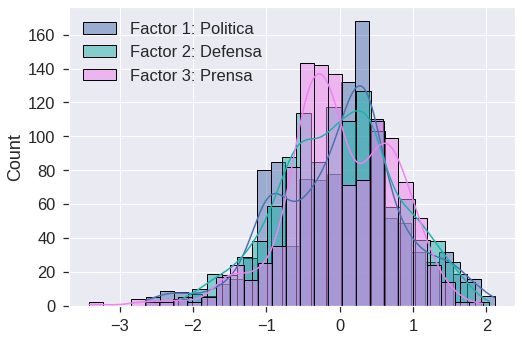

In [59]:
extract_factor_scores = factorize.transform(trust_df)
sns.histplot(extract_factor_scores[:, 0], label="Factor 1: Politica", kde=True)
sns.histplot(extract_factor_scores[:, 1], label="Factor 2: Defensa", kde=True, color="lightseagreen")
sns.histplot(extract_factor_scores[:, 2], label="Factor 3: Prensa", kde=True, color="violet")
plt.legend();

# Dimensionalidad desde Machine Learning 

## Análisis de Componentes Principales

- A diferencia del análisis de factores, el Análisis de Componentes Principales _no_ es un método analítico.
- Es un método de transformación lineal ortogonal que mapea datos en un nuevo sistema de coordenadas, maximizando la varianza de las extrapolaciones.
<br />
<br />
- **Objetivo**: Buscar aquellas dimensiones que maximicen la varianza total de una matriz finita de datos.
    - Por lo general el análisis busca representar un conjunto N-dimensional de datos en un primer eje (aquél que maximize más la varianza), y un segundo eje (el segundo componente que maximice la varianza), reduciendo así la dimensionalidad. 
<br />
<br />
- El Análisis de Componentes Principales busca reducir la redundancia de los datos entre una serie de expansiones basales candidatas.
    - Aquella que aproxime su matriz de covarianza a una matriz diagonal (entradas diagonales cercanas a 1 y triángulos cercanos a 0), se denomina como el _**primer componente principal**_.
    - El proceso se itera, rankeando todas las expansiones basales en términos de maximización de varianza y reducción de redundancia de datos.

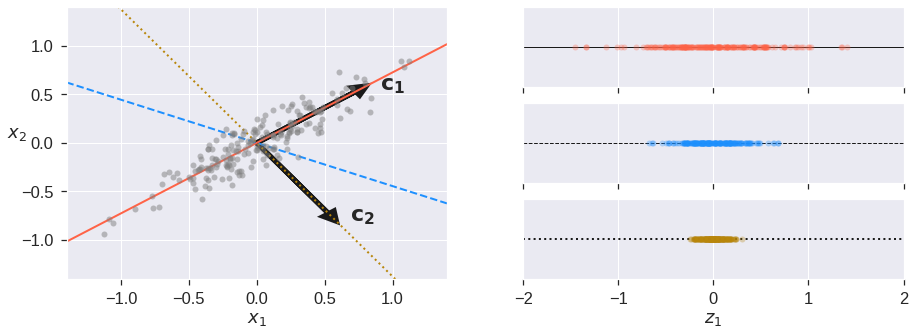

In [62]:
gfx.pca_variance(figsize=(15, 5))

- El objetivo del análisis de componentes principales es obtener dimensiones que _**capturen y mapeen la varianza conjunta**_.
- La recta roja se posiciona como la dimensión que captura una parte substancial de la varianza conjunta entre $x_1$ y $x_2$, dado que pasa de a lo largo de la tendencia. Luego siguen la recta azul y amarilla.
- Optamos por la recta amarilla por sobre la azul dado que ésta _preserva la ortogonalidad_ de la matriz de datos (existe un ángulo de 90 grados entre ambas, lo cual implica que no hay covarianza entre éstas dimensiones).

## Diferencia entre PCA y Análisis Factorial

<a href="https://community.jmp.com/t5/JMP-Blog/Principal-components-or-factor-analysis/ba-p/38347?code=es-ES">Fuente</a>
    
<img src="https://community.jmp.com/t5/image/serverpage/image-id/5945i6C9C25C89DA06AA7/image-dimensions/697x303?v=v2" />

_"Tenga en cuenta que las flechas en PCA apuntan desde las variables medidas al componente principal, y en EFA es al revés. Las flechas representan relaciones causales, de modo que la variabilidad en las variables medidas en PCA causa la variación en el componente principal. Esto contrasta con EFA, donde se considera que el factor latente causa la variabilidad y el patrón de correlaciones entre las variables medidas (Marcoulides y Hershberger, 1997)"_

## Ejemplo: Identificando números escritos
- Una de las principales aplicaciones del PCA es la reducción de dimensionalidad cuando tenemos muchos más atributos que observaciones.
- Un ejemplo clásico de esto es el reconocimiento de imágenes.

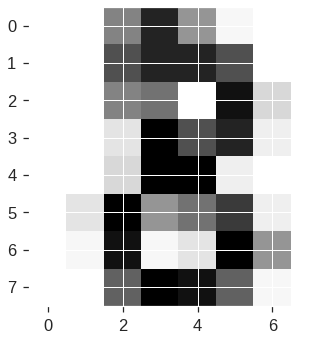

In [63]:
from sklearn.datasets import load_digits

df = load_digits()
plt.imshow(df.data[8].reshape([8, 8]));

- Nuestro objetivo es abstraer las principales características de los trazos al momento de escribir.
- Para ello implementaremos un Análisis de Componentes Principales mediante clase `PCA` del módulo decomposition de la librería `sklearn`.

In [64]:
print("Dimensión original de la base:",df.data.shape)

Dimensión original de la base: (1797, 64)


In [65]:
from sklearn.decomposition import PCA

# Extraemos solamente los 2 primeros componentes principales, indicando n_components=2
dimred = PCA(n_components = 2)

# Se ajusta el PCA en el set de datos y se obtiene los componentes
project_x = dimred.fit_transform(df.data)

print("La nueva dimensión de la base es de:",project_x.shape)

La nueva dimensión de la base es de: (1797, 2)


- Como se ha reducido las dimensiones a 2, es posible visualizar esta representación de los atributos reducidos en un gráfico

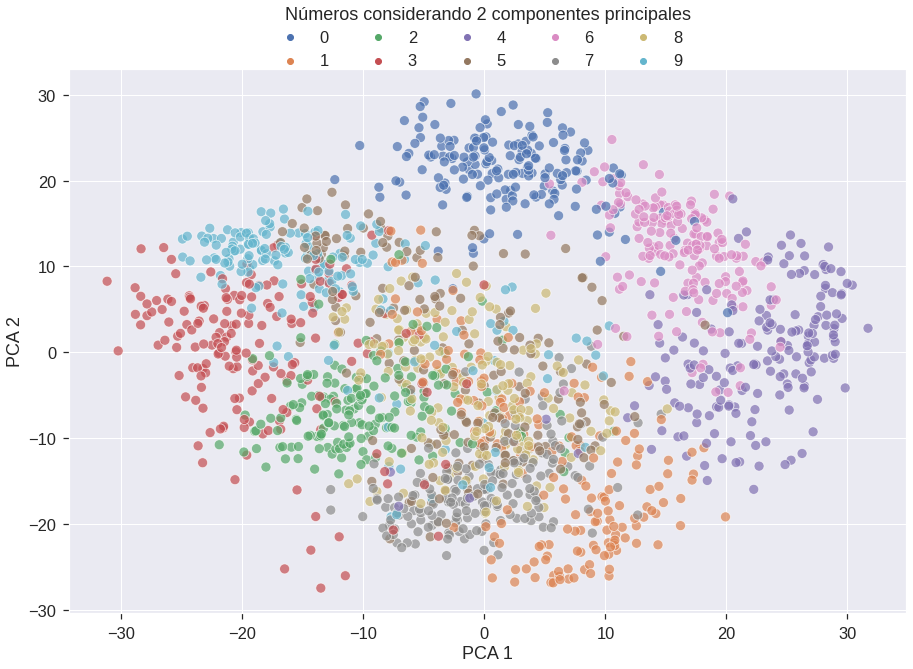

In [74]:
plt.figure(figsize=(15, 10))
sns.scatterplot(
    x=project_x[:, 0], # Se grafica el primer componente principal en el eje x del gráfico
    y=project_x[:, 1], # Se grafica el segundo componente principal en el eje y del gráfico
    hue=df.target,     # Se asigna la lista de colores, correspondiente a la clase de cada registro. De esta forma, asigna un color a cada número.
    palette=sns.color_palette(),
    alpha=0.7,
    s=100
)
plt.title("Números considerando 2 componentes principales", pad=50)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(ncol=5, bbox_to_anchor=(0.75, 1.1));

### Maximizando la varianza
- Parte importante de la implementación de PCA es el estimar cuántos elementos son necesarios para obtener el máximo de varianza explicada. 

In [23]:
print("La varianza explicada de cada dimensión es de:",dimred.explained_variance_ratio_)
print("En conjunto, ambas dimensiones explican la varianza en un: ", sum(dimred.explained_variance_ratio_))

La varianza explicada de cada dimensión es de: [0.14890594 0.13618771]
En conjunto, ambas dimensiones explican la varianza en un:  0.28509364823697836


- Se explora ahora la varianza explicada utilizando distintas cantidades de componentes, tomando como máximo la cantidad original de columnas.

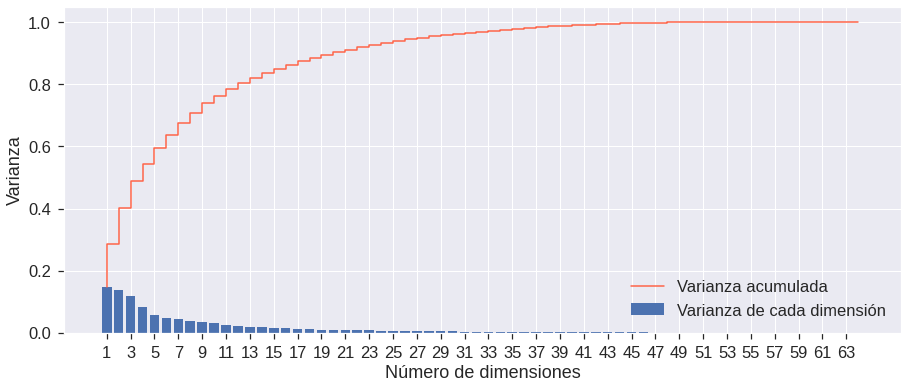

In [24]:
fetch_dims = PCA().fit(df.data)
dims_quant = len(fetch_dims.components_)

plt.figure(figsize=(15, 6))
plt.bar(range(1, dims_quant + 1), fetch_dims.explained_variance_ratio_, label="Varianza de cada dimensión")
plt.step(range(1, dims_quant + 1), np.cumsum(fetch_dims.explained_variance_ratio_), color='tomato', label="Varianza acumulada")
plt.xlabel('Número de dimensiones')
plt.ylabel('Varianza')
plt.xticks(range(1, dims_quant + 1, 2))
plt.legend();

### Componentes
- La representación aproximada de una imagen mediante PCA se realiza en base a la combinación lineal de factores.
- En este caso optimizamos nuestro algoritmo para extraer las primeras 10 dimensiones que representan el mapeo de un número.

In [69]:
pca = PCA(n_components=10)
project_x = pca.fit_transform(df.data)
print("Varianza acumulada con 10 dimensiones:", np.cumsum(pca.explained_variance_ratio_)[-1])

Varianza acumulada con 10 dimensiones: 0.738226223971158


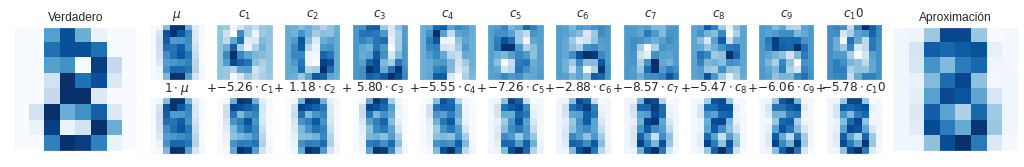

In [72]:
gfx.plot_pca_components(df.data[8], project_x[8], pca.mean_, pca.components_);

- Así, la reconstrucción de cada imagen es una conjetura de coeficientes $\lambda_i$ estimados y multiplicados por la matriz entre 0 y 1 de las trazas.

# Agrupación desde Machine Learning 

## Rudimentos de la Agrupación

- **Objetivo**: Dividir los datos en una serie de grupos en base a una medida de similitud entre los puntos.
- **Limitante no supervisada**: No tenemos certeza sobre la cantidad de grupos.

## KMeans

- La idea de kMeans es desarrollar una segmentación de vectores en un espacio d-dimensional de manera tal de inferir grupos que no se sobrepongan. 

### Pasos de KMeans:

- Asignar una cantidad de clusters.
- Inferir la media para cada cluster determinado en el espacio.
- Para cada observación en el espacio, asignar el cluster más cercano.
- Actualizar la media inferida para todos los puntos.
- Iterar hasta que se satisfaga algún criterio de convergencia (que no se formen nuevos grupos al actualizar las medias).

<a href="https://www.naftaliharris.com/blog/visualizing-k-means-clustering/">Visualización</a>

- En Python, se puede implementar con la clase `KMeans` de `sklearn`

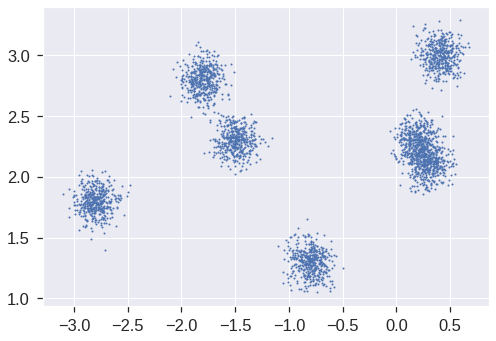

In [75]:
# importamos make_blobs para crear data sintética
from sklearn.datasets import make_blobs

# Definimos los centros para la data sintética
bivariate_mu_params = list([[ 0.2, 2.3], [-1.5 , 2.3], [-2.8, 1.8], [-1.8, 2.8], [-.8, 1.3],[.3, 2.1], [.4, 3]])

# Definimos las varianzas para la data sintética
bivariate_sigma_params = list([0.1, 0.1, 0.1, 0.1, 0.1, .1, .1])

X_mat, y_vec = make_blobs(n_samples=3000, centers=bivariate_mu_params, cluster_std=bivariate_sigma_params, random_state=11238)
plt.scatter(X_mat[:, 0], X_mat[:, 1], s=1);

In [76]:
# importamos el modulo
from sklearn.cluster import KMeans

# instanciamos KMeans en un nuevo objeto, especificando que se usará 7 clusters
kmeans = KMeans(n_clusters=7, random_state=11238)

# obtenemos los resultados
fit_results = kmeans.fit_predict(X_mat)

# Mostramos la frecuencia relativa de cada cluster generado
pd.Series(kmeans.labels_).value_counts('%')

1    0.144333
5    0.143667
4    0.143000
2    0.142667
3    0.142667
0    0.142333
6    0.141333
dtype: float64

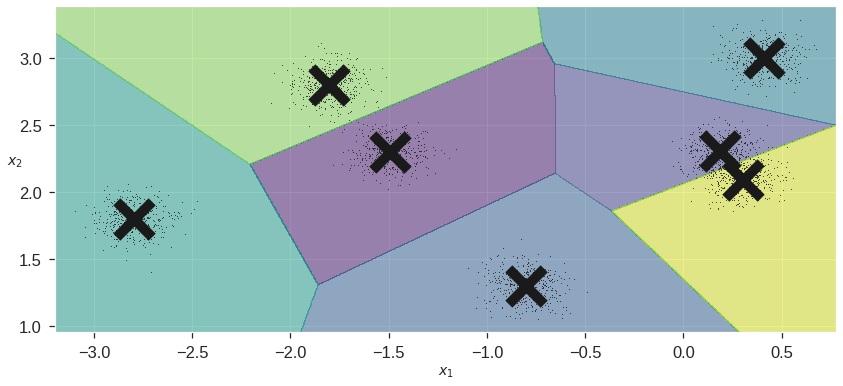

In [77]:
plt.figure(figsize=(14, 6))
gfx.plot_decision_boundaries(kmeans, X_mat)

### Inercia del Modelo
- Si bien no podemos medir el desempeño del modelo (porque no tenemos etiquetas previas), podemos medir la distancia promedio entre cada número y su centroide mediante la inercia, entendida como la suma de distancias cuadráticas.
- Busca medir la distancia promedio entre cada punto y el centroide mediante la suma de distancias (euclídeas) cuadráticas.
- Buscamos obtener una reducción sustancial de las distancias cuadráticas entre los puntos y sus centroides.
- Podemos inferir la cantidad óptima de clusters mediante un gráfico de codo.

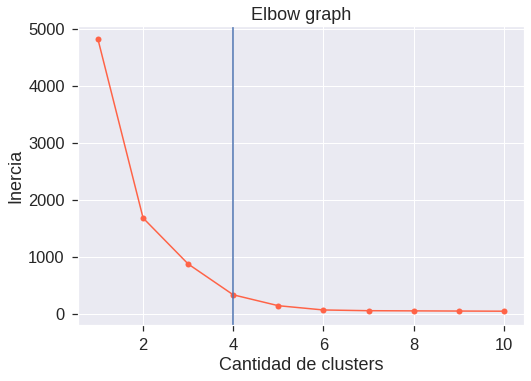

In [78]:
# Generamos una lista para guardar los resultados de inercia, probando entre 1 y 10 clusters
inertia = [
    KMeans(n_clusters=i, random_state=11238).fit(X_mat).inertia_
    for i in range(1, 11)
]

# Graficamos el resultado
plt.plot(range(1, 11), inertia, 'o-', color='tomato')
plt.xlabel("Cantidad de clusters")
plt.ylabel("Inercia")
plt.title("Elbow graph")
plt.axvline(4);